# Analyses of fingerprints

In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# --Machine learning and statistics

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler,  LabelBinarizer
import umap
from sklearn import mixture
import pickle
from scipy.stats import mode
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.spatial import distance_matrix, distance

# Get my functions
functions_path =  prefix + 'representation_learning_variability/Functions/'
os.chdir(functions_path)
# from data_processing import save_and_log
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial/4_analyses/5_clustering_analyses/'
os.chdir(functions_path)
# from clustering_functions import calculate_entropy
functions_path =  prefix + 'representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from plotting_functions import create_grouped_gradient_palette
from one.api import ONE
one = ONE(mode='remote')

In [3]:
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
filename = str(data_path + 'all_sequences_wheel_10-07-2025')
# filename = str(data_path + 'all_sequences_wheel_09-29-2025')
all_sequences = pd.read_parquet(filename)

data_path = prefix + 'representation_learning_variability/paper-individuality/fig4_clustering/'
# cluster_df = pd.read_parquet(data_path+'cluster_per_session')
cluster_df = pd.read_parquet(data_path+'5_cluster_per_session')

mice_to_keep = np.load(data_path+'low_ent_mice.npy', allow_pickle=True)

In [4]:
def expand_from_trial_type(df):
    
    df['feedback'] = df['trial_type'].str.split().str[:1].str.join('')
    df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
    df['block'] = df['trial_type'].str.split().str[2:3].str.join('')
    df['contrast'] = df['trial_type'].str.split().str[1:2].str.join('')
    df['side'] = df['choice'].copy()
    df.loc[(df['feedback']=='correct') & (df['choice']=='right'), 'side'] = 'left'
    df.loc[(df['feedback']=='correct') & (df['choice']=='left'), 'side'] = 'right'
    df['session'] = df['sample'].str.split().str[:1].str.join('')
    df['trial_id'] = df['sample'].str.split().str[1:2].str.join('')
    df['contrast'] = df['contrast'].astype(float)
    df['block'] = df['block'].astype(float)
    df['choice'] = df['trial_type'].str.split().str[3:4].str.join('')
    df.loc[df['choice']=='left', 'choice'] = 0
    df.loc[df['choice']=='right', 'choice'] = 1
    df.loc[df['feedback']=='correct', 'feedback'] = 1
    df.loc[df['feedback']=='incorrect', 'feedback'] = 0
    
    return df

def group_by_var_interest(session_syllables, var_interest, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster', var_interest])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()
    v_int = session_syllables[var_interest].copy()

    for i, interest in enumerate(np.unique(v_int)):
        for c, cluster in enumerate(np.unique(clusters)):
            reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob', var_interest], index=range(use_states * timesteps))
            indices = np.where((session_syllables['session_cluster']==cluster) & (session_syllables[var_interest]==interest))[0]
            syllable_prob = np.array(session_syllables[session_syllables.keys()[4:]])[indices, :].mean(axis=0)

            for t in range(timesteps):
                # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
                #             '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
                #             '111', '211', '311', '411', '511',  '611',  '711']
                reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400','010', '110',
                        '210', '310', '410', '001', '101', '201', '301', '401',  '011',
                        '111', '211', '311', '411']
                reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
                reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
                reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
                reshaped_probs_cluster[var_interest][t*use_states:(t+1)*use_states] = interest
            # Save
            reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

def group_by_cluster(session_syllables, use_states):

    session_syllables = session_syllables.groupby(['mouse_name', 'session', 'session_cluster'])[np.arange(0, np.shape(final_matrix)[1], 1)].mean().reset_index()
    
    timesteps = 40
    reshaped_probs = pd.DataFrame()
    clusters = session_syllables['session_cluster'].copy()

    for c, cluster in enumerate(np.unique(clusters)):
        reshaped_probs_cluster = pd.DataFrame(columns=['syllable', 'timestep', 'cluster', 'prob'], index=range(use_states * timesteps))
        indices = np.where((session_syllables['session_cluster']==cluster))[0]
        syllable_prob = np.array(session_syllables[session_syllables.keys()[3:]])[indices, :].mean(axis=0)

        for t in range(timesteps):
            # reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] = ['000', '100', '200', '300', '400', '500', '600', '700', '010', '110',
            #             '210', '310', '410', '510', '610', '710', '001', '101', '201', '301', '401', '501', '601', '701', '011',
            #             '111', '211', '311', '411', '511',  '611',  '711']
            reshaped_probs_cluster['syllable'][t*use_states:(t+1)*use_states] =  ['000', '100', '200', '300', '400','010', '110',
                        '210', '310', '410', '001', '101', '201', '301', '401',  '011',
                        '111', '211', '311', '411']
            reshaped_probs_cluster['timestep'][t*use_states:(t+1)*use_states] = t
            reshaped_probs_cluster['prob'][t*use_states:(t+1)*use_states] = syllable_prob[t*use_states:(t+1)*use_states]
            reshaped_probs_cluster['cluster'][t*use_states:(t+1)*use_states] = cluster
        # Save
        reshaped_probs = pd.concat([reshaped_probs, reshaped_probs_cluster])
            
    return reshaped_probs

In [5]:
complete_df = expand_from_trial_type(all_sequences)
complete_df = complete_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])
# complete_df = complete_df.merge(trial_clusters_df[['mouse_name', 'session', 'trial_id', 'trial_cluster']], on=['mouse_name', 'session', 'trial_id'])

## Get sequences per trial

In [6]:
var_interest = 'choice'
# var_interest = ''
if len(var_interest) > 0:
    pivoted_df = complete_df.pivot(index=['sample', 'trial_type', 'mouse_name', 'session', var_interest], columns=['broader_label'], values='avg_wheel_vel_binned_sequence').reset_index().dropna()
else:
    pivoted_df = complete_df.pivot(index=['sample', 'trial_type', 'mouse_name', 'session'], columns=['broader_label'], values='avg_wheel_vel_binned_sequence').reset_index().dropna()
pivoted_df = pivoted_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])

In [7]:
epoch_to_analyse = ['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']

sequences_choice = np.vstack(pivoted_df[epoch_to_analyse].apply(lambda row: np.hstack(row), axis=1))  # Transpose to get the right shape
use_sequences = sequences_choice[~np.isnan(sequences_choice).any(axis=1)]

In [8]:
final_matrix = use_sequences.copy()
# plt.imshow(final_matrix, aspect='auto')

In [9]:
session_syllables = pd.DataFrame(use_sequences)
session_syllables['session'] = pivoted_df['session'].copy()
session_syllables['session_cluster'] = pivoted_df['session_cluster'].copy()
session_syllables['mouse_name'] = pivoted_df['mouse_name'].copy()
session_syllables[var_interest] = pivoted_df[var_interest].copy()
use_states = len(np.unique(use_sequences))


([<matplotlib.axis.XTick at 0x751d4fa9e950>,
 [Text(10, 0, 'Quiescence'), Text(20, 0, 'Stimulus'), Text(30, 0, 'Response')])

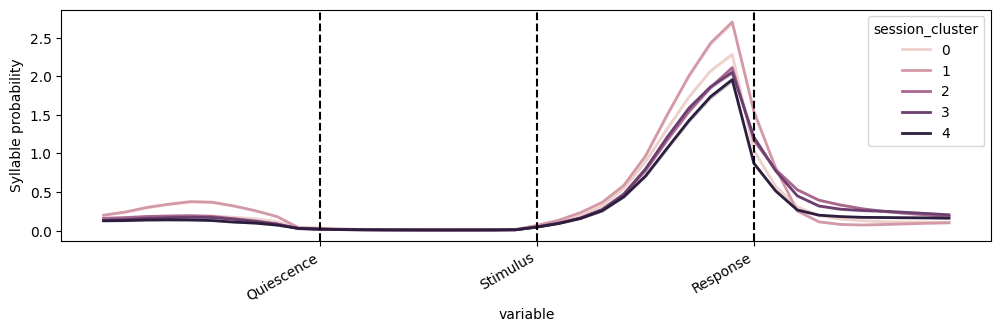

In [10]:
fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 3))
labels = np.arange(0, 6, 1)
# use_data = session_syllables.loc[session_syllables['session_cluster']==cluster]
use_data =  pd.melt(session_syllables, id_vars=['session', 'session_cluster', 'mouse_name'], value_vars=np.arange(0, 40, 1))
sns.lineplot(x='variable', y='value', hue='session_cluster', data=use_data, 
            hue_order=labels, linewidth=2)  #  legend=labels[c]  style=var_interest,

plt.axvline(x=10, color='k', linestyle='--')
plt.axvline(x=20, color='k', linestyle='--')
plt.axvline(x=30, color='k', linestyle='--')
plt.ylabel('Syllable probability')
# axs[c].set_xlabel('')
plt.xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
# axs[c].legend('')
# axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

/tmp/ipykernel_9043/1948038162.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'left' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  session_syllables.loc[session_syllables['choice'] ==0, 'choice'] = 'left'
/tmp/ipykernel_9043/1948038162.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='variable', y='value', data=use_data, style=var_interest,
/tmp/ipykernel_9043/1948038162.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend(loc='upper left', bbox_to_anchor=(1.1, 1))


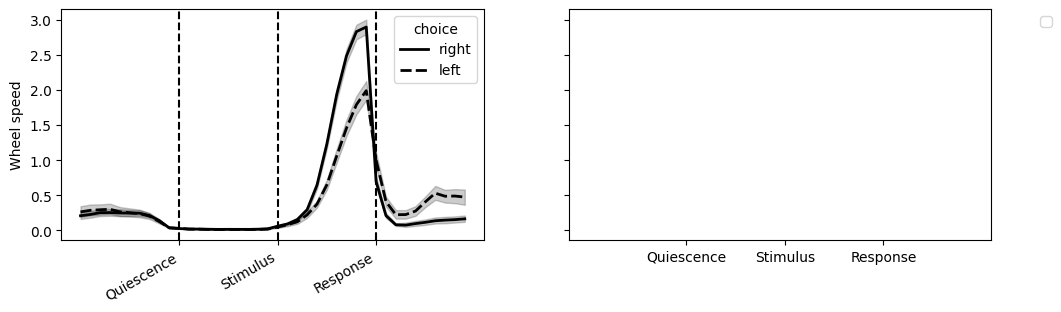

In [11]:
clusters = session_syllables['session_cluster'].unique()
session_syllables.loc[session_syllables['choice'] ==0, 'choice'] = 'left'
session_syllables.loc[session_syllables['choice'] ==1, 'choice'] = 'right'
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 3))

c = 0
use_data = session_syllables.loc[session_syllables['session']=='ae8787b1-4229-4d56-b0c2-566b61a25b77']
use_data =  pd.melt(use_data, id_vars=['session', 'session_cluster', 'mouse_name', var_interest], value_vars=np.arange(0, 40, 1))
sns.lineplot(x='variable', y='value', data=use_data, style=var_interest, 
            ax=axs[c], linewidth=2, color='black', ci=95)  #  legend=labels[c]

axs[c].axvline(x=10, color='k', linestyle='--')
axs[c].axvline(x=20, color='k', linestyle='--')
axs[c].axvline(x=30, color='k', linestyle='--')
axs[c].set_ylabel('Wheel speed')
axs[c].set_xlabel('')
# axs[c].set_ylim([0, 0.6])a
axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
# axs[c].legend('')
axs[1].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

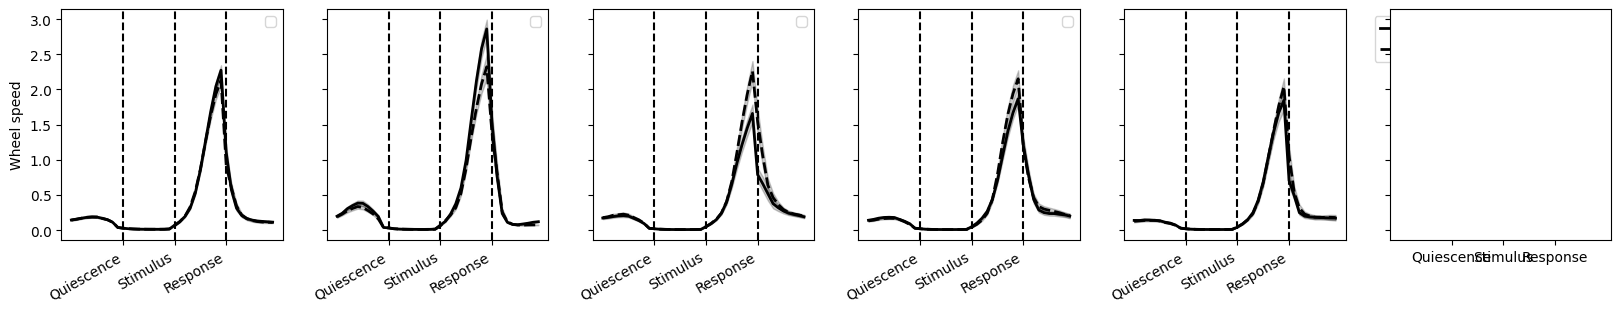

In [12]:
clusters = session_syllables['session_cluster'].unique()
session_syllables.loc[session_syllables['choice'] ==0, 'choice'] = 'left'
session_syllables.loc[session_syllables['choice'] ==1, 'choice'] = 'right'
fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(20, 3))

for c, cluster in enumerate(np.unique(clusters)):
    use_data = session_syllables.loc[session_syllables['session_cluster']==cluster]
    use_data = pd.melt(use_data, id_vars=['session', 'session_cluster', 'mouse_name', var_interest], value_vars=np.arange(0, 40, 1))
    use_data = use_data.groupby(['session', 'choice', 'variable'])['value'].mean().reset_index()
    sns.lineplot(x='variable', y='value', data=use_data, style=var_interest, 
                ax=axs[c], linewidth=2, color='black', errorbar='se')  #  legend=labels[c]

    axs[c].axvline(x=10, color='k', linestyle='--')
    axs[c].axvline(x=20, color='k', linestyle='--')
    axs[c].axvline(x=30, color='k', linestyle='--')
    axs[c].set_ylabel('Wheel speed')
    axs[c].set_xlabel('')
    # axs[c].set_ylim([0, 0.6])a
    axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
    axs[c].legend('')
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

In [30]:
order = ['000', '010', '001', '011', '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411',
         '500', '510', '501', '511', '600', '610', '601', '611',
         '700', '710', '701', '711']
labels = ['VL00', 'VL10', 'VL01', 'VL11', 'Low00', 'Low10',  'Low01', 'Low11',
         'Lowish00', 'Lowish10', 'Lowish01', 'Lowish11', 
         'LL-00', 'LL-10', 'LL-01', 'LL-11', 'LR-00', 'LR-10', 'LR-01', 'LR-11', 
         'HL-00', 'HL-10', 'HL-01', 'HL-11', 'HR-00', 'HR-10', 'HR-01', 'HR-11', 
         'H-00', 'H-10', 'H-01', 'H-11']


order = ['000', '010', '001', '011', 
         '100', '110', '101', '111', '200', '210', '201', '211',
         '300', '310', '301', '311', '400', '410',  '401', '411']
labels = ['Low00', 'Low10',  'Low01', 'Low11',
         'Lowish00', 'Lowish10', 'Lowish01', 'Lowish11', 
         'L-00', 'L-10', 'L-01', 'L-11', 'R-00', 'R-10', 'R-01', 'R-11',
         'H-00', 'H-10', 'H-01', 'H-11']

rename_labels = dict(zip(np.array(order), np.array(labels)))
rename_func = np.vectorize(rename_labels.get)

In [47]:
palette_30 = create_grouped_gradient_palette(n_groups=5, shades_per_group=1, base_palette='Set1')
palette_30_list = [palette_30(i) for i in range(palette_30.N)]  # Extract colors properly

palette_16 = create_grouped_gradient_palette(n_groups=2, shades_per_group=4, base_palette='Set1')
palette_16_list = [palette_16(i) for i in range(palette_16.N)]  # Extract colors properly
state_to_color = dict(zip(order, palette_16_list))

/tmp/ipykernel_4202/2919919549.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['syllable'] = rename_func(use_data['syllable'])
/tmp/ipykernel_4202/2919919549.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['syllable'] = rename_func(use_data['syllable'])
/tmp/ipykernel_4202/2919919549.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

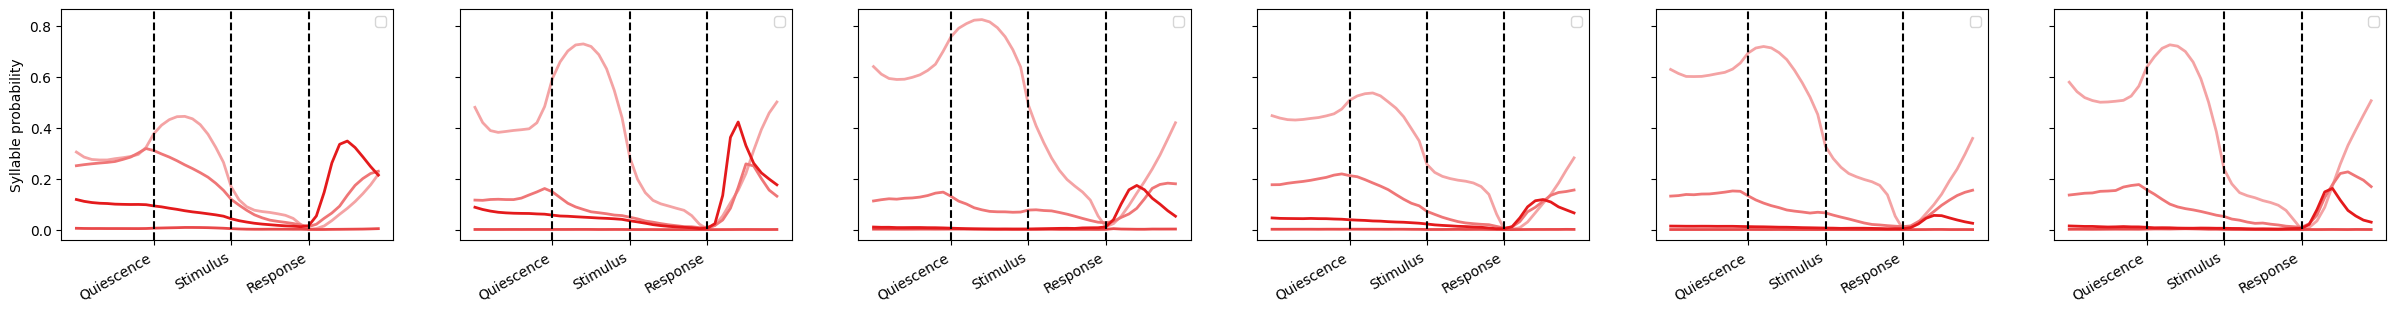

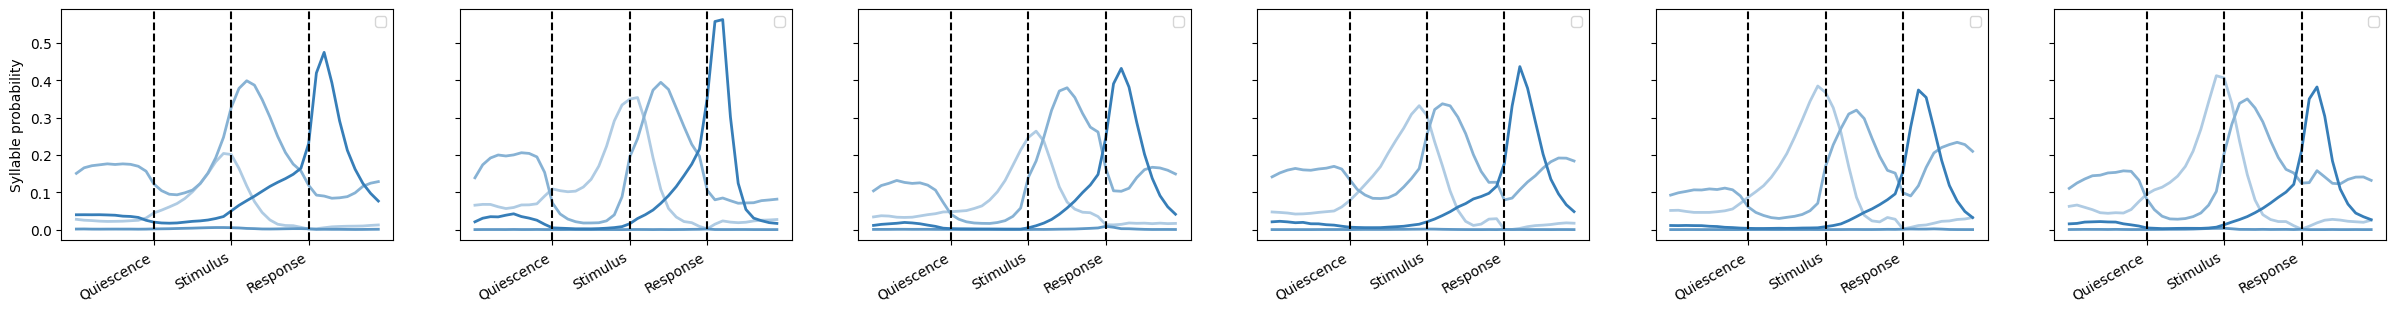

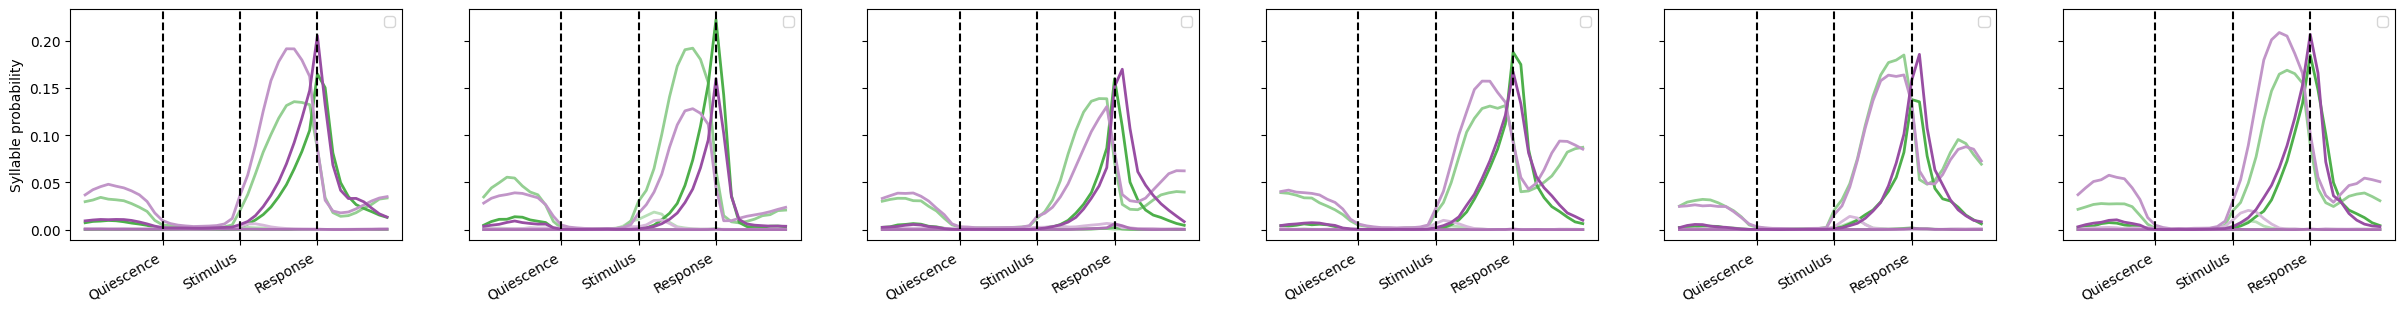

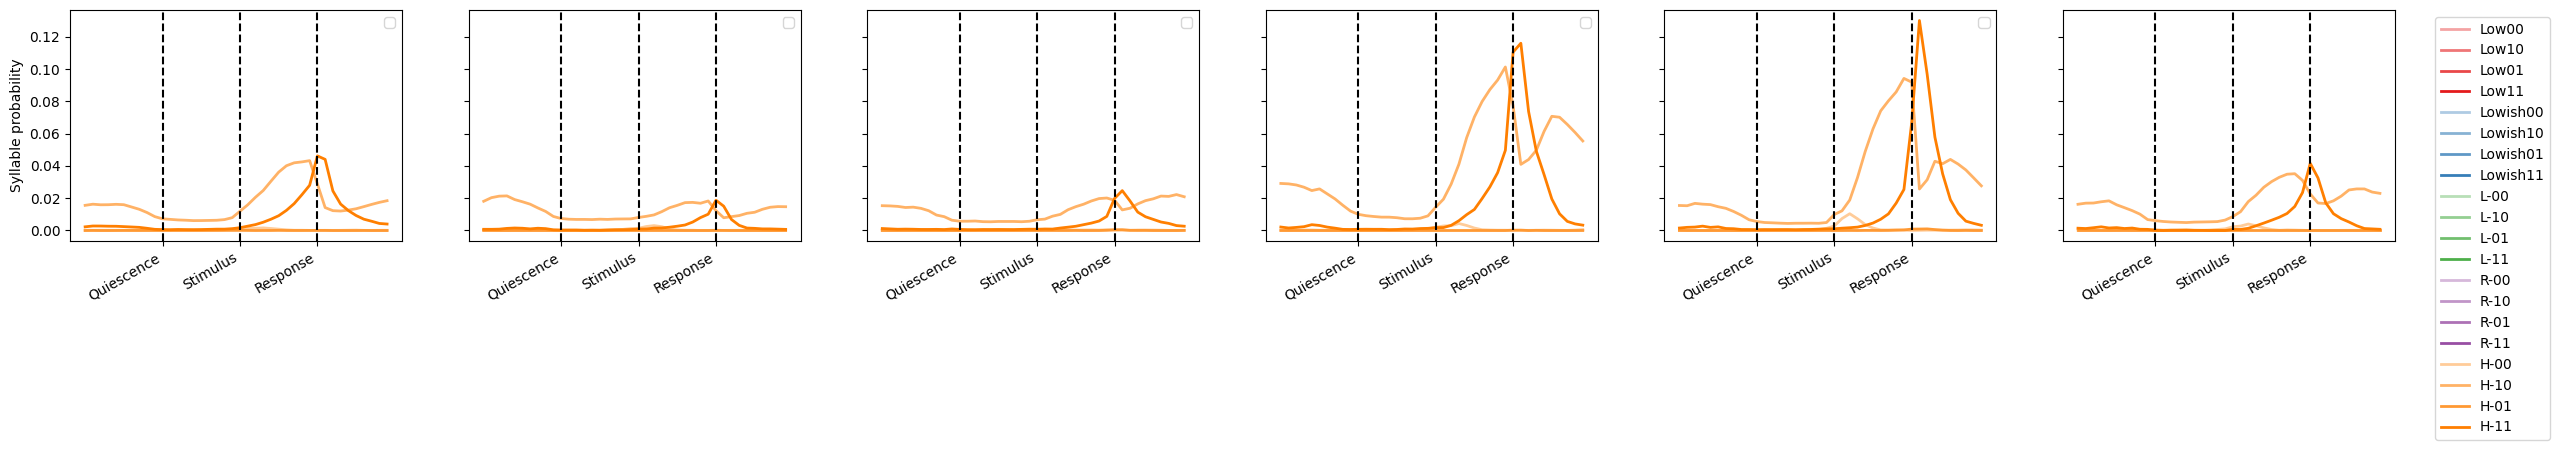

In [15]:
paw_syllable = [['VL00', 'VL10', 'VL01', 'VL11',
                'Low00', 'Low10',  'Low01', 'Low11'],
                ['Lowish00', 'Lowish10', 'Lowish01', 'Lowish11', 'H-00', 'H-10', 'H-01', 'H-11'],
                ['LL-00', 'LL-10', 'LL-01', 'LL-11', 'LR-00', 'LR-10', 'LR-01', 'LR-11'],
                ['HL-00', 'HL-10', 'HL-01', 'HL-11', 'HR-00', 'HR-10', 'HR-01', 'HR-11'],
                
                ]
paw_syllable = [['Low00', 'Low10',  'Low01', 'Low11'],
                ['Lowish00', 'Lowish10', 'Lowish01', 'Lowish11'],
                ['L-00', 'L-10', 'L-01', 'L-11', 'R-00', 'R-10', 'R-01', 'R-11'],
                ['H-00', 'H-10', 'H-01', 'H-11']
                ]

for i in range(4):

    fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(30, 3))

    for c, cluster in enumerate(np.unique(clusters)):
        use_data = reshaped_probs.loc[reshaped_probs['cluster']==cluster]
        use_data['syllable'] = rename_func(use_data['syllable'])
        use_syllables = paw_syllable[i]
        use_data = use_data.loc[use_data['syllable'].isin(use_syllables)]
        sns.lineplot(x='timestep', y='prob', hue='syllable', data=use_data, 
                    ax=axs[c], palette=palette_30_list, hue_order=labels, linewidth=2)  #  legend=labels[c]  style=var_interest,

        axs[c].axvline(x=10, color='k', linestyle='--')
        axs[c].axvline(x=20, color='k', linestyle='--')
        axs[c].axvline(x=30, color='k', linestyle='--')
        axs[c].set_ylabel('Syllable probability')
        axs[c].set_xlabel('')
        # axs[c].set_ylim([0, 0.6])
        axs[c].set_xticks(np.arange(10, 31, 10), ['Quiescence', 'Stimulus', 'Response'], rotation=30, ha='right')
        axs[c].legend('')
axs[c].legend(loc='upper left', bbox_to_anchor=(1.1, 1))

# Plot statistics per fingerprint

In [20]:
trials_df = complete_df.drop(columns=['broader_label', 'avg_wheel_vel_binned_sequence']).drop_duplicates()
# trials_df = trials_df.merge(cluster_df[['mouse_name', 'session', 'session_cluster']], on=['mouse_name', 'session'])

In [21]:
# Get timing info
data_path = prefix + 'representation_learning_variability/paper-individuality/fig1_segmentation/'
states_file = pd.read_parquet(data_path+'states_trial_type_09-29-2025')
vars = ['trial_id', 'session', 'mouse_name']
elongation = pd.DataFrame(states_file.groupby(vars)['elongation'].mean()).reset_index()
elongation['trial_id'] = elongation['trial_id'].astype(str)
response = pd.DataFrame(states_file.groupby(vars)['response'].mean()).reset_index()
response['trial_id'] = response['trial_id'].astype(str)
reaction = pd.DataFrame(states_file.groupby(vars)['reaction'].mean()).reset_index()
reaction['trial_id'] = reaction['trial_id'].astype(str)

del states_file

# Merge
trials_df = trials_df.merge(elongation, on=['session', 'trial_id', 'mouse_name'])
trials_df = trials_df.merge(response, on=['session', 'trial_id', 'mouse_name'])
trials_df = trials_df.merge(reaction, on=['session', 'trial_id', 'mouse_name'])

In [22]:
data_path = prefix + 'representation_learning_variability/DATA/'
# data_path =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/'
learning_df = pd.read_csv(data_path+'learning_private_one.csv')
learning_times = learning_df[['subject_nickname', 'training_time']].drop_duplicates()
learning_times = learning_times.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

data_path =  prefix + 'representation_learning_variability/DATA/'
learning_df = pd.read_parquet(data_path+'training_time_03-21-2025', engine='pyarrow')
learning_times_new = learning_df.rename(columns={"subject_nickname": "mouse_name"}).reset_index()

# new_df = design_df.droplevel(1, axis=1)[['mouse_name', 'session']]
# df = new_df.merge(learning_times, on='mouse_name')
a = learning_times.merge(learning_times_new, on='mouse_name', how='outer')
b = a.loc[a['training_time_x'].isna()]
b = b.rename(columns={"training_time_y": "training_time"}).reset_index()

full_learning = pd.concat([learning_times[['mouse_name', 'training_time']], b[['mouse_name', 'training_time']]]).reset_index()

/tmp/ipykernel_8112/1096352341.py:3: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  learning_df = pd.read_csv(data_path+'learning_private_one.csv')


In [23]:
trials_df = trials_df.merge(full_learning[['mouse_name', 'training_time']], on='mouse_name')

In [14]:
use_data = trials_df.loc[trials_df['mouse_name'].isin(mice_to_keep)]

In [25]:
use_data = trials_df.copy()

/tmp/ipykernel_8112/2464203760.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
/tmp/ipykernel_8112/2464203760.py:26: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))


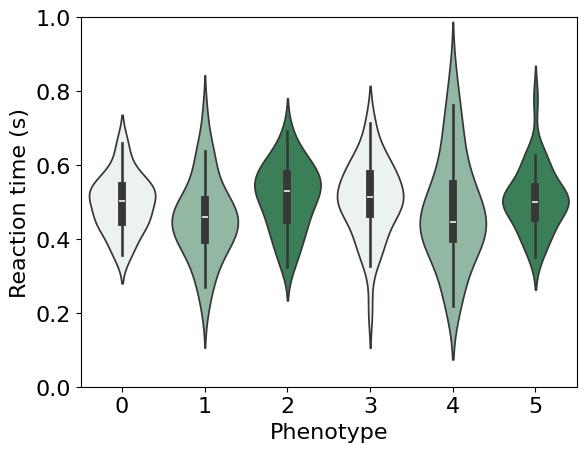

P-value for KW: 0.064
          0         1         2         3         4         5
0  1.000000  0.949535  1.000000  1.000000  1.000000  1.000000
1  0.949535  1.000000  0.116277  0.256374  1.000000  0.582588
2  1.000000  0.116277  1.000000  1.000000  0.985145  1.000000
3  1.000000  0.256374  1.000000  1.000000  1.000000  1.000000
4  1.000000  1.000000  0.985145  1.000000  1.000000  1.000000
5  1.000000  0.582588  1.000000  1.000000  1.000000  1.000000


In [26]:
# --Machine learning and statistics
from scipy.stats import ttest_ind
from sklearn.metrics import f1_score
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

var_1 = 'training_time ~ session_cluster'
var = 'training_time'
var = 'choice'
var_1 = 'choice ~ session_cluster'

data = pd.DataFrame(use_data.groupby(['mouse_name', 'session', 'session_cluster'])[var].mean()).reset_index().dropna()
# data = pd.DataFrame(trials_df.groupby(['mouse_name', 'session_cluster'])[var].mean()).reset_index().dropna()
# data = pd.DataFrame(new_df.groupby(['mouse_name', 'session_cluster'])[var].mean()).reset_index().dropna()
# data = data[['session_cluster', var]]
data[var] = data[var].astype(float)

model = ols(var_1, data=data).fit()

plt.rcParams.update({'font.size': 16})
sns.violinplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.barplot(x='session_cluster', y=var, data=data, palette=sns.light_palette("seagreen", 3, as_cmap=False))
# sns.scatterplot(x='part_cluster', y=var, data=data, color='black')
# plt.xticks([0, 1, 2, 3, 4, 5], [0, 1, 2, 3, 4, 5])
plt.ylim([0, 80])
plt.ylim([0, 4])
# plt.ylim([0.5, 1])
plt.ylim([0, 1])
plt.xlabel('Phenotype')
plt.ylabel('Proportion correct')
plt.ylabel('Reaction time (s)')
# plt.ylabel('Training time (sessions)')
plt.show()
    
#keep_clusters = [ 0,  2,  3,  4,  5,  6,  8, 10]
group_1 = data.loc[data['session_cluster']==0, var]
group_2 = data.loc[data['session_cluster']==1, var]
group_3 = data.loc[data['session_cluster']==2, var]
group_4 = data.loc[data['session_cluster']==3, var]
group_5 = data.loc[data['session_cluster']==4, var]
group_6 = data.loc[data['session_cluster']==5, var]

stat, p_value = stats.kruskal(group_1, group_2, group_3, group_4, group_5, group_6)
# stat, p_value = stats.kruskal(group_1, group_2, group_3, group_4, group_5)


print(f"P-value for KW: {p_value:.3f}")

posthoc = sp.posthoc_dunn(data.dropna(), val_col=var, group_col='session_cluster', p_adjust='bonferroni')
print(posthoc)